# Topic extraction from the GEPRiS dataset and creation of an user-centric visualisation
Author: Tim Korjakow        
Summer term 2018      
Freie Universität Berlin     
Fachgebiet Human-Centered Computing

![Process graph](nlpflowchart.svg)

In [1]:
# general imports
import numpy as np
#import sklearn
import os

# data wrangling
import json
import spacy
spacy.prefer_gpu()
from spacy_langdetect import LanguageDetector
import psycopg2
from multiprocessing import Pool, cpu_count

# document embedding
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from gensim.matutils import corpus2csc
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, strip_short
import scipy

# topic extraction
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF as NonnegativeMatrixFactorization
from gensim.models.coherencemodel import CoherenceModel
import keras
from sklearn.preprocessing import normalize


#clustering
from sklearn.cluster import KMeans

# projection into 2d
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE

# linearization
from lapjv import lapjv
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
from numpy.linalg import norm
from sklearn.preprocessing import normalize

# quality metrics of the clustering
from sklearn.metrics import silhouette_samples

# interactivity
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider, Dropdown
import ipywidgets as widgets
from IPython.display import display, Javascript, HTML
import pickle

#2d plot
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, OpenURL, TapTool
from bokeh.plotting import figure, ColumnDataSource
from bokeh.palettes import d3, brewer
from bokeh.layouts import row, column
output_notebook()
import matplotlib.pyplot as plt

# 3d plot
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True) # for offline mode use

Using TensorFlow backend.


Loading BokehJS ...

## Loading and Cleaning
The first step in every NLP project which works with texts is always the preparation of the input data. In this example the Project dump from GEPRIS is loaded and the project descriptions are extracted. After that the texts get cleaned by removing all non-alphabetic chars and all stopwords from the texts. English texts are getting filtered in oder to make the analysis simpler and more comparable.

In [28]:
with open(os.environ['PG_PASSWORD']) as password_file:
    password = password_file.read().strip()
    conn = psycopg2.connect(dbname="ikon", user="ikonuser", password=password, port=5432, host='Postgres')
class DataLoader(object):
    def __init__(self, query, clean=True, stream=False, workers=cpu_count()):
        self.query = query
        self.clean = clean
        self.nlp = spacy.load('de', disable=["ner", "tagger"])
        #self.nlp.add_pipe(self.nlp.create_pipe('sentencizer'))
        self.nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
        self.nlp.Defaults.stop_words |= self.loadGermanStopwords()
        self.nlp.Defaults.stop_words |= self.loadEnglishStopwords()
        data = self.chunkify(self.loadFromDB(self.query).fetchall(), workers)
        with Pool(workers) as pool:
            self.data = [item for sublist in pool.map(self.preprocessText, data) for item in sublist]
        
        self.filepath = get_tmpfile(str(hash(tuple(self.data))))
        with open(self.filepath, "w") as file:
            for text, *args in self.data:
                file.write("%s\n" % " ".join(text))
            
    def __iter__(self):
        self.pos = 0
        return self
    
    def __next__(self):
        if self.pos >= len(self.data):
            raise StopIteration
        text, *args = self.data[self.pos]
        self.pos += 1
        return TaggedDocument(text, [self.pos])
    
    def  __getitem__(self, pos):
        text, *args = self.data[pos]
        return TaggedDocument(text, [pos])
    
    def __len__(self):
        return len(self.data)
    
    def getIDs(self):
        return [id for (text, id, title) in self.data]
    
    def getTitles(self):
        return [title for (text, id, title) in self.data]
        
    def loadFromDB(self, query):
        cursor = conn.cursor()
        cursor.execute(query)
        return cursor
        
    def loadGermanStopwords(self):
        with open('../data/stopwords_de.json', 'r') as datafile:
            return set(json.load(datafile))

    def loadEnglishStopwords(self):
        with open('../data/stopwords_eng.json', 'r') as datafile:
            return set(json.load(datafile))
        
    def preprocessText(self, results):
        texts, *args = zip(*results)
        data = []
        for doc, *args in zip(self.nlp.pipe(texts, batch_size=100, n_threads=-1), *args):
            if(doc._.language['language'] == 'de'):
                data.append((tuple([token.lemma_ for token in doc if self.filterType(token)]), *args))
        return data
    
    def chunkify(self, lst, n):
        return [lst[i::n] for i in range(n)]
        
    def filterType(self, token):
        return token.is_alpha and not (token.is_stop or token.like_num or token.is_punct) and len(token.lemma_) > 3

In [45]:
traindata = %time DataLoader('''SELECT FIRST(project_abstract), FIRST(id), FIRST(title) \
                                FROM projects WHERE project_abstract NOT LIKE '%Keine Zusammenfassung%' \
                                GROUP BY project_abstract \
                                ;''')
mfndata = DataLoader('''SELECT abstract, id, title \
                        FROM project_view \
                        WHERE institution_id = 13232 AND abstract NOT LIKE '%Zusammenfassung%';''')

CPU times: user 5.09 s, sys: 1.6 s, total: 6.69 s
Wall time: 18min 12s


In [46]:
len(mfndata)

82

## Document Embedding

### TF-IDF
*Summary*:
This technique vectorizes a corpus, e.g. a collection of documents, by counting all appearences of words in the corpus and computing the tf-idf measure for each document, word pair.

In [47]:
class TfidfModelExtended(TfidfModel):
    def top_words(self, vector, dct=None ,topn=5):
        if isinstance(vector, scipy.sparse.csr_matrix):
            vector = vector.todense()
        return [dct.get(entry) for entry in np.argpartition(np.asarray(vector).ravel(), -topn)[-topn:]]

In [48]:
dct = %time Dictionary(doc.words for doc in traindata)  # fit dictionary
traincorpus = [dct.doc2bow(doc.words) for doc in traindata]  # convert corpus to BoW format
tfidf_model = %time TfidfModelExtended(traincorpus)  # fit model

CPU times: user 17.4 s, sys: 171 ms, total: 17.6 s
Wall time: 17.7 s
CPU times: user 5.09 s, sys: 20.7 ms, total: 5.11 s
Wall time: 5.11 s


In [49]:
mfncorpus = [dct.doc2bow(doc.words) for doc in mfndata]  # convert corpus to BoW format
docs_vectorized_tfidf = corpus2csc(tfidf_model[mfncorpus]).T

### Doc2Vec
*Summary*:
This technique vectorizes a corpus, e.g. a collection of documents, by counting all appearences of words in the corpus and computing the tf-idf measure for each document, word pair.

In [50]:
class Doc2VecExtended(Doc2Vec):
    def top_words(self, vector, dct=None, topn=5):
        return [word for word, prob in self.wv.similar_by_vector(vector, topn=topn)]

In [51]:
print('Doc2Vec setup and vocabulary building:')
doc2vec_model = %time Doc2VecExtended(corpus_file=traindata.filepath, total_words=dct.num_pos, vector_size=100, window=20, min_count=10, workers=4, epochs=20)
print('Doc2Vec training:')
%time doc2vec_model.train(corpus_file=traindata.filepath, total_words=dct.num_pos, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Doc2Vec setup and vocabulary building:


/tf/.venv/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



CPU times: user 12min 58s, sys: 2.41 s, total: 13min 1s
Wall time: 3min 33s
Doc2Vec training:
CPU times: user 12min 47s, sys: 2.49 s, total: 12min 49s
Wall time: 3min 25s


In [52]:
docs_vectorized_doc2vec = np.array([doc2vec_model.infer_vector(doc.words) for doc in mfndata])

In [53]:
print(docs_vectorized_doc2vec.shape)

(82, 100)


# Topic extraction

## Latent Semantic Analysis
*Summary*:
The LSA transforms an corpus from its word space given by the tf-idf matrice into its semantic space. In this semantic space the dimensions denote topics in the corpus and every document vector is a linear combination of all the implicitly extracted topics.

In [54]:
def LSA(tfs,num_topics=40):
    print('LSA:')
    lsa = %time TruncatedSVD(n_components=num_topics, random_state=0).fit(tfs)
    return lsa.transform(tfs), lsa

## Autoencoder
Summary: **Coming soon**

In [55]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 40  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
input_dim = doc2vec_model.docvecs.vectors_docs.shape[1]
print(input_dim)
# this is our input placeholder
input_img = Input(shape=(input_dim,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

100


In [56]:
input_train = normalize(doc2vec_model.docvecs.vectors_docs, axis=0, norm='l1')
input_test = normalize(docs_vectorized_doc2vec, axis=0, norm='l1')
history = autoencoder.fit(input_train, input_train,
                epochs=150,
                batch_size=256,
                shuffle=True,
                validation_data=(input_test, input_test),
                verbose=1)

Train on 82241 samples, validate on 82 samples
Epoch 1/150
82241/82241 [==============================] - 1s 10us/step - loss: 0.1178 - val_loss: 0.0093
Epoch 2/150
82241/82241 [==============================] - 1s 7us/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/150
82241/82241 [==============================] - 1s 7us/step - loss: 9.9958e-04 - val_loss: 8.8345e-04
Epoch 4/150
82241/82241 [==============================] - 1s 7us/step - loss: 5.3391e-04 - val_loss: 6.3468e-04
Epoch 5/150
82241/82241 [==============================] - 1s 7us/step - loss: 3.5651e-04 - val_loss: 5.1847e-04
Epoch 6/150
82241/82241 [==============================] - 1s 7us/step - loss: 2.6449e-04 - val_loss: 4.5237e-04
Epoch 7/150
82241/82241 [==============================] - 1s 7us/step - loss: 2.0871e-04 - val_loss: 4.1018e-04
Epoch 8/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.7153e-04 - val_loss: 3.8114e-04
Epoch 9/150
82241/82241 [==============================] - 1s 7u

82241/82241 [==============================] - 1s 7us/step - loss: 1.1254e-05 - val_loss: 2.4980e-04
Epoch 73/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.1078e-05 - val_loss: 2.4966e-04
Epoch 74/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.0907e-05 - val_loss: 2.4953e-04
Epoch 75/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.0742e-05 - val_loss: 2.4941e-04
Epoch 76/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.0580e-05 - val_loss: 2.4929e-04
Epoch 77/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.0424e-05 - val_loss: 2.4917e-04
Epoch 78/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.0272e-05 - val_loss: 2.4906e-04
Epoch 79/150
82241/82241 [==============================] - 1s 7us/step - loss: 1.0124e-05 - val_loss: 2.4895e-04
Epoch 80/150
82241/82241 [==============================] - 1s 7us/step - loss: 9.9802e-06 - val_loss

82241/82241 [==============================] - 1s 7us/step - loss: 5.1839e-06 - val_loss: 2.4544e-04
Epoch 144/150
82241/82241 [==============================] - 1s 7us/step - loss: 5.1437e-06 - val_loss: 2.4541e-04
Epoch 145/150
82241/82241 [==============================] - 1s 7us/step - loss: 5.1040e-06 - val_loss: 2.4539e-04
Epoch 146/150
82241/82241 [==============================] - 1s 7us/step - loss: 5.0650e-06 - val_loss: 2.4536e-04
Epoch 147/150
82241/82241 [==============================] - 1s 7us/step - loss: 5.0265e-06 - val_loss: 2.4534e-04
Epoch 148/150
82241/82241 [==============================] - 1s 7us/step - loss: 4.9885e-06 - val_loss: 2.4531e-04
Epoch 149/150
82241/82241 [==============================] - 1s 7us/step - loss: 4.9510e-06 - val_loss: 2.4529e-04
Epoch 150/150
82241/82241 [==============================] - 1s 7us/step - loss: 4.9140e-06 - val_loss: 2.4526e-04


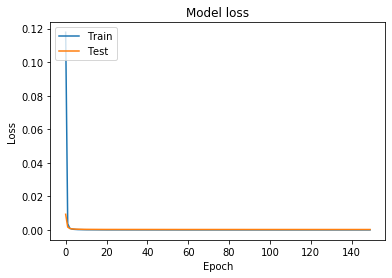

In [57]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Evaluate topic extraction

## Get top words for each dimension
In order to get the words which are most important for each dimension (which correspond to topics), the standard basis in the topic space is converted back into the word space. These are exactly the eigenvectors of data. Now the top n biggest entries and their corresponding words form the top words.

In [58]:
def get_top_words_dim(model, feature_names, n_top_words):
    dim_topics = {}
    for topic_idx, topic in enumerate(model.components_):
        dim_topics[topic_idx] = [feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return dim_topics

## Clustering

### K-Means
Summary: Given a clustering the LDA can be used to find a projection into a lower dimensional space which maximizes inter-class variance and minimizes intra-class variance. This leads to neater cluster, but is grounded in the hypotheses that the clusters have some real semantic meaning. Otherwise it may enforce preexisting biases.

In [59]:
def clusterNumberHeuristic(tfs):
    return (tfs.shape[0]*tfs.shape[1])//tfs.count_nonzero()

def cluster(tfs_reduced, num_topics=10):
    print('K-Means:')
    km = %time KMeans(n_clusters=num_topics).fit(tfs_reduced)
    return km

### Get top words for each cluster
The process is similar to the one for getting the top words for each dimension. But in this case the cluster centers from the clustering step are transformed back into the word space and analysed. This is based on the assumption that the cluster center represents the set of all documents in the corrsponding cluster.

In [60]:
def get_top_words_point(model, point, feature_names, n_top_words):
    point = np.array(point).reshape(1,-1)
    point.reshape(1, -1)
    word_space_point = model.inverse_transform(point)
    return [feature_names[j] for j in word_space_point.argsort()[0][:-n_top_words - 1:-1]]

# Embedding into 2D

## Linear Discriminant Analysis
*Summary*:
Given a clustering the LDA can be used to find a projection into a lower dimensional space which maximizes inter-class variance and minimizes intra-class variance. This leads to neater cluster, but is grounded in the hypotheses that the clusters have some real semantic meaning. Otherwise it may enforce preexisting biases.

In [61]:
def dimReductionLDA(tfs_reduced, clusters, targetDim=2):
    lda = LinearDiscriminantAnalysis(n_components=targetDim)
    print('LDA:')
    tfs_2d = %time lda.fit(tfs_reduced, clusters.labels_).transform(tfs_reduced)
    return tfs_2d, lda

## tSNE
*Summary*:


*In-depth explanation*:

In [62]:
def dimReductiontSNE(tfs_reduced, perplexity=30, learning_rate=100, targetDim=2):
    print('t-SNE:')
    tfs_2d = %time TSNE(n_components=targetDim, perplexity=perplexity, learning_rate=learning_rate).fit_transform(tfs_reduced)
    return tfs_2d

# Linearize results into a grid

In [63]:
def mapToSpaceSampling(points):
    # just take the first n² < #points Points
    points = points[: int(np.sqrt(len(points)))**2]
    grid = np.dstack(np.meshgrid(np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), int(np.sqrt(len(points)))),
                       np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), int(np.sqrt(len(points)))))).reshape(-1, 2)
    cost = cdist(points, grid, "sqeuclidean").astype(np.float64)
    print(cost.shape)
    cost *= 100000 / cost.max()
    row_ind_lapjv, col_ind_lapjv, _ = lapjv(cost, verbose=True, force_doubles=True)
    return grid[row_ind_lapjv]

In [64]:
def computeClusterTopography(points, values, width, height, interpolation='linear'):
    # lay grid over the points so that all points are covered
    grid_x, grid_y = np.mgrid[np.min(points[:,0]):np.max(points[:,0]):width*1j, np.min(points[:,1]):np.max(points[:,1]):height*1j]
    return griddata(np.array(points), np.array(values[:len(points)]), (grid_x, grid_y), method=interpolation, fill_value=np.min(values[:len(points)]))

In [65]:
def compute(tfs, emb_model, targetDim, dimreduction, clustering, embedding, num_topics, num_clusters, perplexity, learning_rate, error, interpolation, viz, width, height):
    
    if dimreduction == 'LSA':
        tfs_reduced, red_model = LSA(tfs, num_topics=num_topics)
    elif dimreduction == 'NMF':
        tfs_reduced, red_model = NMF(tfs, num_topics=num_topics)
    elif dimreduction == 'Autoencoder':
        tfs_reduced, red_model = encoder.predict(tfs), None
    else:
        return 'No dimensionality reduction technique was selected!'
    
    if clustering == 'KMEANS':
        clusters = cluster(tfs_reduced, num_topics=num_clusters)
    else:
        return 'No clustering technique was selected!'
    
    if embedding == 'LDA':
        tfs_embedded, lda = dimReductionLDA(tfs_reduced, clusters=clusters, targetDim=targetDim)
    elif embedding == 'tSNE':
        tfs_embedded = dimReductiontSNE(tfs_reduced, perplexity=perplexity, learning_rate=learning_rate, targetDim=targetDim)
    else:
        return 'No dimensionality reduction technique was selected!'
    
    # compute linearization
    tfs_mapped = mapToSpaceSampling(tfs_embedded) if targetDim == 2 else np.array([[0,0]]*len(tfs_embedded)) 
    
    # compute top words
    cluster_words = [emb_model.top_words(np.mean(tfs[clusters.labels_==cluster], axis=0), dct=dct, topn=5) for cluster in range(num_clusters)]
    top_words = [emb_model.top_words(project, dct=dct, topn=5) for project in tfs]
    # compute coherence score
    cm = CoherenceModel(topics=cluster_words, corpus=mfncorpus, dictionary=dct, coherence='u_mass')
    print("Coherence score: ", cm.get_coherence())
    
    #compute cluster topography
    similarity_to_cluster_centers = [norm(x-clusters.cluster_centers_[clusters.labels_[i]]) for i,x in enumerate(tfs_reduced)]
    similarity_to_cluster_centers = similarity_to_cluster_centers / -norm(similarity_to_cluster_centers)
    reduction_error = np.max(lda.decision_function(tfs_reduced), axis=1) if (embedding == 'LDA') else [0]* len(tfs_embedded)
    reduction_error = reduction_error / norm(reduction_error)
    interpolated_topography = computeClusterTopography(tfs_embedded if viz == 'scatter' else tfs_mapped, similarity_to_cluster_centers if error=='cluster_error' else silhouette_samples(tfs_reduced, clusters.labels_), width, height, interpolation)
    return tfs_reduced, clusters, tfs_embedded, tfs_mapped, cluster_words, top_words, similarity_to_cluster_centers, reduction_error, interpolated_topography

# Visualization

In [66]:
def draw_scatter(data, width=600, height=600, viz='scatter'):
    display(Javascript("""
        (function(element){
            require(['scatter'], function(scatter) {
                scatter(element.get(0), %s, %d, %d, %s);
            });
        })(element);
    """ % (json.dumps(data), width, height, json.dumps(viz))))

In [67]:
def save(payload):
    name = "c" + str(payload['params']['num_clusters']) +"-t" + str(payload['params']['num_topics']) + "_" + str(payload['params']['embedding'])
    if payload['params']['embedding'] == 'tSNE':
        name += "_p" + str(payload['params']['perplexity']) + "-lr" + str(payload['params']['learning_rate'])
    with open('./dumps/' + name + '.json', 'w') as dumpfile:
        json.dump(payload, dumpfile, sort_keys=True, indent=4, ensure_ascii=False)

In [68]:
def visualize(targetDim=2,tfs=None,dimreduction='LSA', clustering='KMEANS', embedding='LDA', num_topics=20, num_clusters=3, perplexity=5, learning_rate=200, error='cluster_error', interpolation='linear', viz='scatter', fake=''):
    # viz dimensions
    width = 600
    height = 600
    payload = {}
    
    
    if not fake:
        # compute all necessary stuff
        tfs, model = pickle.loads(tfs)
        tfs_reduced, clusters, tfs_embedded, tfs_mapped, cluster_words, top_words, similarity_to_cluster_centers, reduction_error, interpolated_topography = compute(tfs, model, targetDim, dimreduction, clustering, embedding, num_topics, num_clusters, perplexity, learning_rate, error, interpolation, viz, width, height)

        [print(i, words) for i,words in enumerate(cluster_words)]
        colours = d3['Category10'][num_clusters]
        #ids, titles, texts = [list(elem) for elem in zip(*loadProjects())]
        if targetDim == 2:
            # configure bokeh plot                   
            source = ColumnDataSource(data=dict(
                x=tfs_embedded[:, 0],
                y=tfs_embedded[:, 1],
                x_mapped=tfs_mapped[:, 0],
                y_mapped=tfs_mapped[:, 1],
                ids=mfndata.getIDs(),
                titles=mfndata.getTitles(),
                colours=np.array(colours)[clusters.labels_],
                labels=clusters.labels_
            ))

            TOOLTIPS = [
                ("index", "$index"),
                ("id", "@ids"),
                ("title", "@titles"),
            ]
            # scatterplot
            scatter = figure(plot_width=800, plot_height=800, title=None, toolbar_location="below", tooltips=TOOLTIPS, tools='tap,pan,wheel_zoom,save')
            scatter.scatter('x', 'y', size=10,color='colours', legend='labels', source=source)
            url = 'http://gepris.dfg.de/gepris/projekt/@ids'
            taptool = scatter.select(type=TapTool)
            taptool.callback = OpenURL(url=url)

            # mapped scatterplot
            mapped_scatter = figure(plot_width=800, plot_height=800, title=None, toolbar_location="below", tooltips=TOOLTIPS, tools='tap,pan,wheel_zoom')
            mapped_scatter.scatter('x_mapped', 'y_mapped', size=50,color='colours', legend='labels', source=source)
            url = 'http://gepris.dfg.de/gepris/projekt/@ids'
            taptool = mapped_scatter.select(type=TapTool)
            taptool.callback = OpenURL(url=url)
            #show(row(scatter, mapped_scatter))
        else:

            source = go.Scatter3d(
                x=tfs_embedded[:, 0],
                y=tfs_embedded[:, 1],
                z=tfs_embedded[:, 2],
                mode='markers',
                marker=dict(
                    size=2,
                    color=clusters.labels_,                # set color to an array/list of desired values
                    colorscale='Viridis',   # choose a colorscale
                    opacity=0.8
                )
            )

            data = [source]
            layout = go.Layout(
                margin=dict(
                    l=0,
                    r=0,
                    b=0,
                    t=0
                )
            )
            fig = go.Figure(data=data, layout=layout)
            iplot(fig, filename='3d-scatter-colorscale')

        payload = {
            'params': {
                'targetDim': targetDim,
                'dimreduction': dimreduction,
                'clustering': clustering,
                'embedding': embedding,
                'num_topics': num_topics,
                'num_clusters': num_clusters,
                'perplexity': perplexity,
                'learning_rate': learning_rate
            },
            'project_data': [{'id':pid,'reducedpoint': reducedpoint, 'embpoint':embpoint, 'mappoint':mappoint, 'cluster':cluster, 'error':error, 'title': title, 'words': words} for pid, reducedpoint, embpoint, mappoint, cluster, error, title, words in zip(
                mfndata.getIDs(),
                tfs_reduced.tolist(),
                tfs_embedded.tolist(),
                tfs_mapped.tolist(),
                clusters.labels_.tolist(),
                similarity_to_cluster_centers.tolist(),
                mfndata.getTitles(),
                top_words

            )],
            'cluster_data': {
                'cluster_words': cluster_words,
                'cluster_colour': colours
            },
            'cluster_topography': np.flip(interpolated_topography.T, axis=0).flatten().tolist()
        }
        save(payload)
    else:
        with open(fake, 'r') as input_data:
            payload = payload=json.load(input_data)
    display(HTML(filename="scatter.css.html"))
    display(Javascript("require.config({paths: {d3: 'https://d3js.org/d3.v5.min'}});"))
    display(Javascript(filename="scatter.js"))
    draw_scatter(payload, width, height, viz)
        


In [69]:
def s(x,y):
    return IntSlider(min=x,max=y, value=(y-x)//2, continuous_update=False)

w = interactive(visualize,targetDim=s(2,3),tfs=Dropdown(options=[('Doc2Vec', pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), ('TfIdf', pickle.dumps((docs_vectorized_tfidf, tfidf_model)))], value=pickle.dumps((docs_vectorized_doc2vec, doc2vec_model))), dimreduction=['LSA', 'NMF', 'Autoencoder'], clustering=['KMEANS'], embedding=['LDA', 'tSNE'], num_topics=s(4,48), num_clusters=s(4,10), perplexity=s(5,50), learning_rate=s(100,1000),error=['silhouette', 'cluster_error'], interpolation=['linear', 'cubic', 'nearest'], viz=['scatter', 'linearized'], fake='')
output = w.children[-1]
#output.layout.height = '2000px'
display(w)


interactive(children=(IntSlider(value=2, continuous_update=False, description='targetDim', max=3, min=2), Drop…